## Example 1:  Linear Regression (NumPy)##

In this example, we will fit the equation of a line to a data set using a training process analagous to the manner in which we would train a neural network. The training process in this example uses only [`numpy`](https://numpy.org) to implement gradient descent and backpropagation.

**Generate the Data**

Use `numpy` to randomly generate a "linear" data set.

In [ ]:
import numpy as np

# Number of data points
N = 100

# Generate data
np.random.seed(1234)  # Derandomize the data generation
X = np.linspace(-10, 10, N)
noise = np.random.normal(0, 3, N)

y = 2 * X + 5 + noise  # y is a linear function of X

**Display the Data**

Use [`matplotlib`](https://matplotlib.org) to produce a scatter plot of the data set.

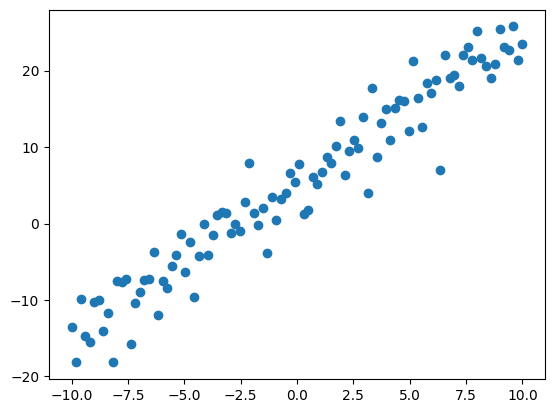

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.show()

**Fit a Line to the Dataset via Gradient Descent**

We are assuming that our model is a linear equation.

> $\hat{\!y} = mx + b$

Find the slope $m$ and the intercept $b$ by training those parameters on the data. Note that the training process in this example uses the entire data set for each pass rather than using samples to estimate the gradient. The end result is that the parameters $m$ and $b$ are trained using pure *gradient descent*.

In [ ]:
# Initialize the parameters
m = np.float32(np.random.randn())  # randn returns a Python float; convert to np.float32
b = np.float32(np.random.randn())

print(f"Initial Result: y = {m.round(2)}x + {b.round(2)}\n".replace("+ -", "- "))

# Set the learning rate (step size)
lr = 0.01

# Training loop -- each iteration of the loop is a pass thru the data set
print(f"Training:\n\n{' t':4} {'  loss':8}\n{'-'*4} {'-'*8}")
for t in range(1000):
    # Forward pass: compute predicted y
    y_pred = m * X + b

    # Compute the loss by comparing the predicted value to the actual value
    loss = 1/N * ((y_pred - y) ** 2).sum()  # Mean Squared Error
    if t % 100 == 0:
        print(f"{t:4} {loss:8.4f}")

    # Backprop to compute the gradient of loss with respect to m and b
    grad = 2.0 * (y_pred - y)  # Derivative of loss function
    grad_m = 1/N * (grad * X).sum()  # Chain rule for derivative wrt m
    grad_b = 1/N * grad.sum()  # Chain rule for derivative wrt b

    # Update weights via gradient descent
    m -= lr * grad_m
    b -= lr * grad_b

print(f"{t+1:4} {loss:8.4f}\n")
print(f"Final Result: y = {m.round(2)}x + {b.round(2)}")

Initial Result: y = 0.28999999165534973x + 0.5699999928474426

Training:

 t     loss  
---- --------
   0 127.6211
 100   9.2812
 200   8.9252
 300   8.9190
 400   8.9189
 500   8.9189
 600   8.9189
 700   8.9189
 800   8.9189
 900   8.9189
1000   8.9189

Final Result: y = 1.99x + 5.11


**Check the Output Against the Classic Implementation Linear Regression**

We can use [`scikit-learn`](https://scikit-learn.org) to check the output of the training process in the previous cell against a standard implementation of linear regression.



In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X.reshape(-1, 1), y)  # reshape x into a column vector

print(f"Classic Result: y = {model.coef_[0].round(2)}x + {model.intercept_.round(2)}")

Classic Result: y = 1.99x + 5.11


**Plot the Fitted Line Against the Original Data**

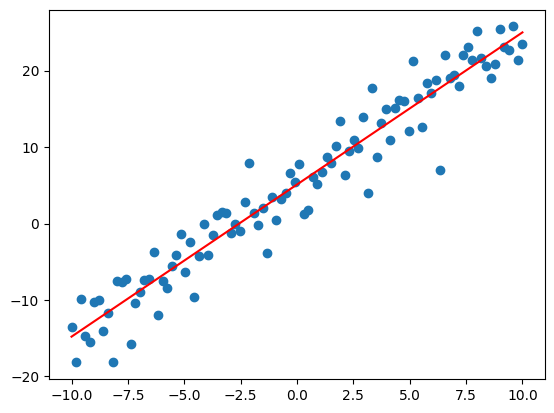

In [ ]:
plt.scatter(X, y)  # Original data

y_plot = m * X + b  # Fitted line
plt.plot(X, y_plot, color="red")

plt.show()



---



## Example 2:  Curve Fitting (PyTorch)

**Generate the Data**

Use [`PyTorch`](https://pytorch.org) to randomly generate a data set.

In [ ]:
import torch

# Derandomize -- set the seed so that the noise term is always the same
torch.manual_seed(12345)

# Create a data set
N = 200  # sample size of the data set

X = 2 * torch.rand(N, 1) - 1  # Column vector of N random values in [-1, 1]
noise = torch.normal(0, 1, (N,1))  # Column vector of N values from std normal distrbution

#y = 9.45 * X ** 5 + 10.53 * X ** 3 - 2 * X ** 2 + 4.5 * X + noise
y = 5 * torch.sin(2 * torch.pi * X) + noise

**Display the Data**

Use [`matplotlib`](https://matplotlib.org) to produce a scatter plot of the data set.

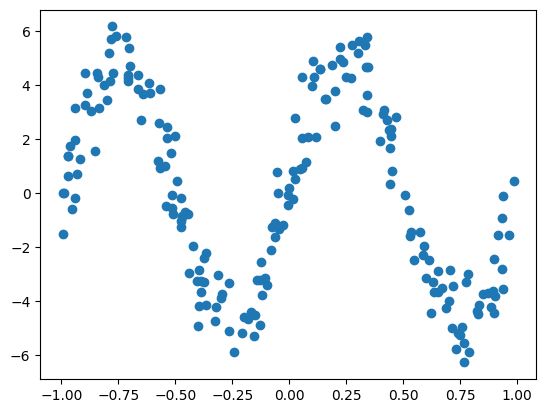

In [ ]:
# Plot the data
plt.scatter(X, y)
plt.show()

**Subclass the base neural network**

Next we create a subclass of `nn.Module`. The `__init__` method should specify the layers and the corresponding activation functions for the neural network. The `forward` method should specify the forward propagation through the network.

In the next block of code, we create a class for a simple `Perceptron` with one hidden layer. The number of nodes in the hidden layer is a parameter. By default, the activation function for the hidden layer is the sigmoid function

> $f(x) = \frac{1}{1 + e^{-x}}$

In [ ]:
from torch import nn

# Perceptron with 1 hidden layer and single node in the output layer; note that
# the input layer and the output activation are implicit, ie f(x) = x
class Perceptron(nn.Module):

    def __init__(self, hidden_nodes=4, activation_fn=nn.Sigmoid):
      super().__init__()
      self.hidden_layer = nn.Linear(1, hidden_nodes)
      self.hidden_activation = activation_fn()
      self.output_layer = nn.Linear(hidden_nodes, 1)

    def forward(self, X):
      X = self.hidden_activation(self.hidden_layer(X))
      X = self.output_layer(X)

      return X

**Train the network**

Now that we have a Python class to represent the neural network architecture, we can begin training the network on the actual data. The basic approach is to forward propagate the input data through the network and compare the network's prediction against the actual target data for the same input features. To quantitatively compare a prediction against the actual data, we need to chose a *loss function*. The standard choice of loss function for a regression problem is *mean-squared error*:


> $L = \frac{1}{n}\sum_{i=1}^{n}\left(\hat{y_i} - y_i\right)^2$


To improve the ability of the network to generate accurate predictions, we use *stochastic gradient descent* to adjust the weights of the network in way that will decrease the loss $L$ on the next iteration of the training process. The specific value of the adjustment is computed as a *gradient* with respect to the weights of the network:


> $W_{n+1} = W_n - \eta\nabla L$


In intuitive terms, we are seeking the right combination of weights that will minimized the loss between the network's prediction and the actual target values. Each iteration of the training process is adjusting the weights in the direction of *steepest descent*. By always moving in the direction of steepest descent, we are hoping to land at the *global minimum*.


The actual gradient is calculated through *backpropagation*. Recursively calculate the value of the gradient by working backwards from the output layer to the input layer. In order to speed up the training process, we *estimate* the gradient using a random sample of the training data. A side effect of using estimates for the gradient is that the loss is no longer guaranteed to decrease from iteration to iteration.

In [ ]:
# Training hyperparameters
LEARNING_RATE = .0001
EPOCHS = 20000
BATCH_SIZE = 20

# Create an instance of the neural net
model = Perceptron() # 4 hidden nodes and sigmoid activation

# Choose+initialize a loss function and an optimizer -- MSE and SGD
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=.99)

# Randomly divide data between training and test sets
permute = torch.randperm(N)  # shuffle the numbers 0, 1, ..., N - 1
train_size = int(.8 * N)  # 80% of data for training
test_size = N - train_size

X_train = X[permute[0:train_size]]
y_train = y[permute[0:train_size]]

X_test = X[permute[train_size:]]
y_test = y[permute[train_size:]]

# Save some data
epoch_save_freq = 200 # Frequency with which to save data
epoch_print_freq = 1000
train_data = []
test_data = []

# Train the net -- each epoch is one pass through the data set
print(f"Training:\n\n{'Epoch':5} {'Tr. Loss':8}\n{'-'*5} {'-'*8}")

batches_per_epoch = train_size//BATCH_SIZE  # divide the data into batches; note the integer division
for epoch in range(EPOCHS):
  # Shuffle the data every epoch in order to create a random sample
  permute = torch.randperm(train_size)  # shuffle the numbers 0, 1, ..., train_size - 1
  X_shuffled = X_train[permute]  # use the permutation to index X in a random order
  y_shuffled = y_train[permute]  # same for y

  # Calculate SGD using batches of batch_size
  for i in range(batches_per_epoch):
    # Grab data in batches
    X_batch = X_shuffled[i:(i+BATCH_SIZE)]
    y_batch = y_shuffled[i:(i+BATCH_SIZE)]

    # Zero out the gradient from the previous iteration
    optimizer.zero_grad()

    # Forward pass -- compute output of the network for the current set of weights
    y_pred = model(X_batch)

    # Compute the loss by comparing the predicted value to the actual value
    loss = loss_fn(y_pred, y_batch)  # Computes 1/batch_size * ((y_pred - y) ** 2).sum()

    # Backpropagation
    loss.backward()  # numerically compute gradient via d(loss_fn)/dw for each w

    # Adjust the weights -- gradient descent
    optimizer.step()

    # End of inner training loop

  # Save some data every few epochs for later graphing and analysis
  epoch = EPOCHS if (epoch == (EPOCHS - 1)) else epoch  # if this is the last epoch
  if epoch % epoch_save_freq == 0:
    # Print the training loss
    if epoch % epoch_print_freq == 0:
      print(f"{epoch:5d} {loss:8.2f}")

    # Save the training loss at the end of every epoch
    train_data.append(loss.item())

    # Evaluate the model on the test data
    with torch.no_grad():
      test_loss = loss_fn(model(X_test), y_test)
      test_data.append(test_loss.item())

Training:

Epoch Tr. Loss
----- --------
    0    14.31
 1000    10.80
 2000     2.85
 3000     1.89
 4000     2.58
 5000     1.86
 6000     1.37
 7000     1.34
 8000     1.26
 9000     1.87
10000     0.92
11000     1.74
12000     1.11
13000     1.29
14000     0.66
15000     0.86
16000     0.66
17000     1.57
18000     1.26
19000     0.99
20000     1.56


**Evaluate the training process**

Since we are training the network to minimize the loss function, graphing loss vs number of training iterations (epochs) can often give us insight into whether or not the training process was successful.

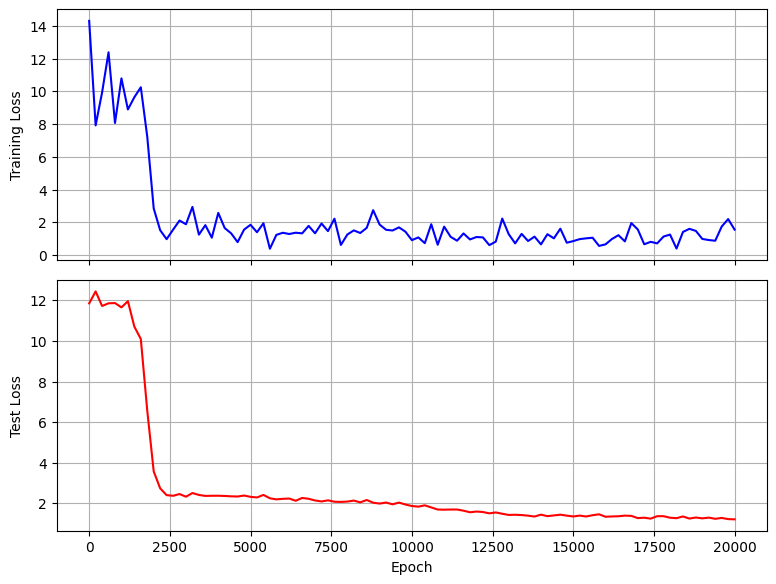

In [ ]:
# X-axis data, ie epochs
xs = np.arange(0, EPOCHS+1, epoch_save_freq)

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot the training loss on the first axis (ax1)
ax1.plot(xs, train_data, color='b')
ax1.set_ylabel('Training Loss')
ax1.grid(True)

# Plot the test loss on the second axis (ax2)
ax2.plot(xs, test_data, color='r')
ax2.set_ylabel('Test Loss')
ax2.set_xlabel('Epoch')
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Plot the Fitted Curve Against the Original Data**

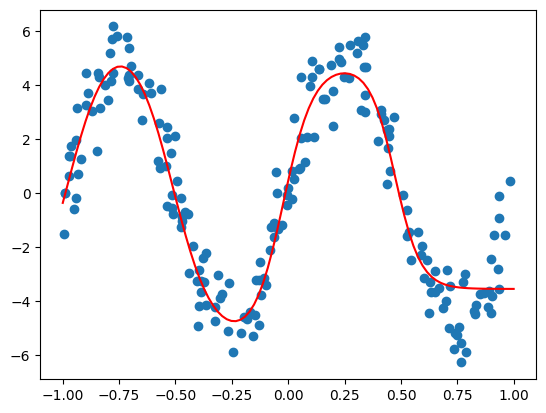

In [ ]:
# Original data
plt.scatter(X, y)  # Original data

# Fitted curve
X_plot = torch.linspace(-1, 1, 100).reshape(-1,1)
y_plot = model(X_plot).detach().numpy()
plt.plot(X_plot, y_plot, color="red")

plt.show()



---



## Example 3:  Image Classification (PyTorch)

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset consisting of images of articles of clothing. There are 60,000 examples in the training set and 10,000 examples in the test set. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Our goal in this example is to train a neural network that can classify an image as one of ten categories of clothing.

**Load the Data**

Load the data set into Python.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Fetch the data set
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4695806.58it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 336206.37it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1974224.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10548254.51it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



**Define the structure of the network**

Create a multi-layer (full connected) perceptron as subclasses `nn.Module`. The input features are the pixels of the image converted into a 1D vector. The output is 1 of 10 class labels. Note the use of `nn.Sequential` to create a pipeline of layers and activation functions.

In [ ]:
class MLPerceptron(nn.Module):

  def __init__(self, hidden_neurons=64):
    # Call the initialization method of nn.Module
    super().__init__()

    # Define the structure of the network
    self.input_layer = nn.Flatten()  # transform a 2D image into 1D vector
    self.hidden_layers = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
    )
    self.output_layer = nn.Linear(128, 10)

  def forward(self, X):
    X = self.input_layer(X)
    X = self.hidden_layers(X)
    X = self.output_layer(X)

    return X

**Train and test the network**

To train the network, we need to choose a loss function in order to evaluate the performance of the network on the training data. For classification problems, `nn.CrossEntropyLoss` is a good choice.

We also need to validate the network against data from the test set in order to demonstrate that, among other issues, that the training process is not overfitting to the training data. Since the main block of code will use the validation process in a few locations, we create a helper function for looping over the test data.

In [ ]:
def test(model, dataloader, loss_fn):
  # Store some information about the dataset
  size = len(dataloader.dataset)
  num_batches = len(dataloader)  # dataloader divides data set into batches

  # Validate the network on the images drawn from a test data set
  with torch.no_grad():
    total_loss = correct = 0
    for X, y in dataloader:
      # Forward pass -- compute the predicted class using the network with the current set of weights
      y_pred = model(X)  # returns activation "energy" per class label

      # Compute the loss by comparing the predicted "energy" for each class to the actual class
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()

      # Choose the label with highest activation
      labels = y_pred.argmax(1)  # choose the label with highest "energy"
      correct += (labels == y).sum().item()

  # Calculate and return some summary statistics
  accuracy = correct / size * 100  # percent correct predictions
  avg_loss = total_loss / num_batches

  return accuracy, avg_loss

Create an instance of the multi-layer perceptron. Setup the loss function and the optimizer. Repeat the train/test cycle for the predetermined number of epochs.

In [ ]:
# Create an instance of the neural net
model = MLPerceptron()

# Hyperparameters
LEARNING_RATE = .1
EPOCHS = 20
BATCH_SIZE = 64

# Choose a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()  # Loss function for classification problems
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Use a DataLoader to manage the random sampling and batching for SGD
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Apply the network to the test set without any training
test_accuracy, test_loss = test(model, test_loader, loss_fn)

# Save some data for later analysis
batch_save_freq = 100

train_loss_data = []

test_loss_data = []
test_accuracy_data = []

# Train the net for multiple epochs
print(f"Training Loop ({test_accuracy:>0.1f}% test accuracy at the start of training):\n")

train_size = len(training_loader.dataset)
batches_per_epoch = len(training_loader)  # batches created by data loader
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1:>2d} .", end="")

    # Train the network using batches of images drawn from training_loader
    total_loss = batch = 0
    for X, y in training_loader:  # X = batch of images, y = classes
      # Zero out any gradients from the previous iteration
      optimizer.zero_grad()

      # Forward pass -- compute the predicted class using the network with the current set of weights
      y_pred = model(X)  # forward propagation

      # Compute the loss by comparing the predicted "energy" for each class to the actual class
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()

      # Backpropagation -- calculate the gradient
      loss.backward()

      # Adjust the weights -- gradient descent
      optimizer.step()

      # Display progress
      if (batch % batch_save_freq == 0):
        print(".", end="")
      batch += 1

      # End of inner training loop

    # Calculate and store training statistics for the current epoch
    train_loss = total_loss / batches_per_epoch
    train_loss_data.append(train_loss)

    # Validate the network on the images drawn from test_loader
    test_accuracy, test_loss = test(model, test_loader, loss_fn)
    test_accuracy_data.append(test_accuracy)
    test_loss_data.append(test_loss)

    # Print a progress report for the current epoch
    print(f" Training loss = {train_loss:>1.4f} |",
          f"Test loss = {test_loss:>1.4f}, accuracy = {test_accuracy:>0.1f}%")

print("\nDone!")

Training Loop (11.2% test accuracy at the start of training):

Epoch  1 ........... Training loss = 0.6785 | Test loss = 0.5769, accuracy = 80.8%
Epoch  2 ........... Training loss = 0.4372 | Test loss = 0.4966, accuracy = 82.4%
Epoch  3 ........... Training loss = 0.3873 | Test loss = 0.4043, accuracy = 85.3%
Epoch  4 ........... Training loss = 0.3595 | Test loss = 0.3798, accuracy = 86.1%
Epoch  5 ........... Training loss = 0.3372 | Test loss = 0.4110, accuracy = 84.6%
Epoch  6 ........... Training loss = 0.3199 | Test loss = 0.4161, accuracy = 84.6%
Epoch  7 ........... Training loss = 0.3080 | Test loss = 0.3738, accuracy = 86.4%
Epoch  8 ........... Training loss = 0.2941 | Test loss = 0.3988, accuracy = 85.8%
Epoch  9 ........... Training loss = 0.2855 | Test loss = 0.3675, accuracy = 86.6%
Epoch 10 ........... Training loss = 0.2746 | Test loss = 0.3683, accuracy = 87.0%
Epoch 11 ........... Training loss = 0.2673 | Test loss = 0.3758, accuracy = 86.8%
Epoch 12 ........... Tra

**Loss and Accuracy Plots**

Unlike the previous examples, we cannot easily visualize the network's functionality. However, by graphing loss for both the training and test sets, we can get better sense of how the training process unfolded. One of the major concerns would be overfitting the network to the training data.

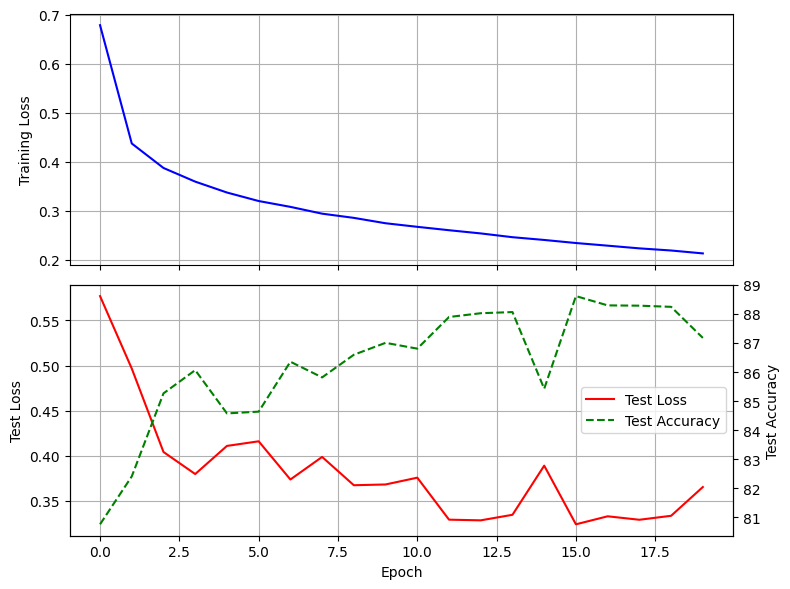

In [ ]:
# X-axis data, ie epochs
xs = np.arange(0, EPOCHS)

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot the training loss on the first axis (ax1)
ax1.plot(xs, train_loss_data, color='b')
ax1.set_ylabel('Training Loss')
ax1.grid(True)

# Plot the test loss on the second axis (ax2)
tlp, = ax2.plot(xs, test_loss_data, color='r')
ax2.set_ylabel('Test Loss')
ax2.set_xlabel('Epoch')
ax2.grid(True)

ax2a = ax2.twinx()
tap, = ax2a.plot(xs, test_accuracy_data, color='g', linestyle="dashed")
ax2a.set_ylabel('Test Accuracy')
ax2.legend([tlp, tap], ["Test Loss", "Test Accuracy"], loc='center right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()